In [41]:
import os
import glob
import shutil
import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

from ciao_contrib.cda.data import download_chandra_obsids
import ciao_contrib.runtool as rt

%matplotlib inline

This list is based on the a webchaser search for Cas A observations with ACIS-I. Some of them are not on the I3 chip, but the fasted to see which ones are good for comparison is to just download everything since files are small because observations are short.

In [23]:
rt.find_chandra_obsid("Cas A", instrument='acisi', download='all', grating='none')


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  evt1     fits       38 Mb    already downloaded
  evt2     fits       24 Mb    already downloaded
  vv       pdf        13 Mb    already downloaded
  asol     fits        1 Mb    already downloaded
  cntr_img jpg       612 Kb    already downloaded
  bias     fits      493 Kb    already downloaded
  bias     fits      436 Kb    already downloaded
  bias     fits      434 Kb    already downloaded
  bias     fits      434 Kb    already downloaded
  bias     fits      431 Kb    already downloaded
  bias     fits      430 Kb    already downloaded
  osol     fits      372 Kb    already downloaded
  osol     fits      358 Kb    already downloaded
  eph1     fits      281 Kb    already downloaded
  eph1     fits      274 Kb    already downloaded
  cntr_img fits      261 Kb    already downloaded
  eph1     fits      252 Kb    already down

Next, we want to find which of the datasets actually have I3 data because some of them were used to calibrate other chips and I3 was not even switched on.

In [24]:
obsids = [int(s) for s in glob.glob('[0-9]*')]
obsids.sort()

In [25]:
# Delete directories that have no photons on I3
for o in [int(s) for s in glob.glob('[0-9]*')]:
    evt2 = glob.glob(f'{o}/primary/*evt2*')
    evt2 = Table.read(evt2[0], hdu='EVENTS')
    if (evt2['ccd_id'] == 3).sum() == 0:
        shutil.rmtree(str(o))

In [26]:
rt.chandra_repro(','.join([i for i in glob.glob('[0-9]*')]), outdir="", cleanup=False, clobber=True)


Running chandra_repro
version: 30 September 2020



Processing input directory '/Users/hamogu/projects/Chandraprojects/dPHA/194'

Resetting afterglow status bits in evt1.fits file...

Running acis_build_badpix and acis_find_afterglow to create a new bad pixel file...

Running acis_process_events to reprocess the evt1.fits file...
Filtering the evt1.fits file by grade and status and time...
Applying the good time intervals from the flt1.fits file...
The new evt2.fits file is: /Users/hamogu/projects/Chandraprojects/dPHA/194/repro/acisf00194_repro_evt2.fits

Updating the event file header with chandra_repro HISTORY record
Creating FOV file...

The data have been reprocessed.
Start your analysis with the new products in
/Users/hamogu/projects/Chandraprojects/dPHA/194/repro


Processing input directory '/Users/hamogu/projects/Chandraprojects/dPHA/218'

Resetting afterglow status bits in evt1.fits file...

Running acis_build_badpix and acis_find_afterglow to create a new bad pixel file...



The following obsrevations do not have CTI applied, because CALDB has not relevant entries: 218, 219, 210, 217

### Remove t_gain from all evt2 files

In [48]:
for f in glob.glob('[0-9]*/repro/*repro_evt1.fits'):
    rt.acis_process_events.punlearn()
    rt.acis_process_events(infile=f, 
                           outfile=os.path.join(os.path.dirname(f), 'evt1_notgain.fits'),
                           apply_cti=True, apply_tgain=False,
                           ctifile="CALDB",
                           doevtgrade=True, calculate_pi=True, stop='none',
                           clobber=True)

## Filter for grade, status, and focal plane temperature

In [31]:
mtl = Table.read('10642/repro/acisf10642_000N002_mtl1.fits', hdu='MTL')

ObsID 194   : mean FP_Temp 153.4 K, sigma 0.07 K
ObsID 218   : mean FP_Temp 173.7 K, sigma 0.03 K
ObsID 6737  : mean FP_Temp 153.4 K, sigma 0.00 K
ObsID 1546  : mean FP_Temp 153.3 K, sigma 0.07 K
ObsID 226   : mean FP_Temp 153.3 K, sigma 0.03 K
ObsID 219   : mean FP_Temp 173.7 K, sigma 0.03 K
ObsID 210   : mean FP_Temp 173.7 K, sigma 0.01 K
ObsID 217   : mean FP_Temp 173.7 K, sigma 0.03 K
ObsID 235   : mean FP_Temp 153.3 K, sigma 0.03 K
ObsID 5162  : mean FP_Temp 153.4 K, sigma 0.01 K
ObsID 233   : mean FP_Temp 153.3 K, sigma 0.04 K
ObsID 5155  : mean FP_Temp 153.5 K, sigma 0.03 K
ObsID 234   : mean FP_Temp 153.3 K, sigma 0.03 K
ObsID 23264 : mean FP_Temp 153.3 K, sigma 0.00 K
ObsID 23263 : mean FP_Temp 153.3 K, sigma 0.00 K
ObsID 2869  : mean FP_Temp 153.3 K, sigma 0.07 K
ObsID 10642 : mean FP_Temp 153.6 K, sigma 0.00 K
ObsID 23262 : mean FP_Temp 153.3 K, sigma 0.00 K
ObsID 23265 : mean FP_Temp 153.3 K, sigma 0.00 K
ObsID 2876  : mean FP_Temp 155.6 K, sigma 0.08 K
ObsID 9698  : mean F

Text(0.5, 0, 'Time (ks)')

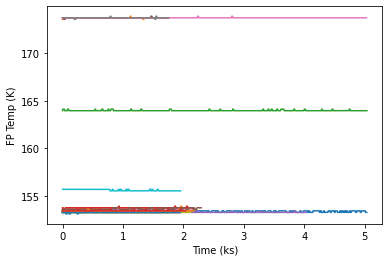

In [46]:
for f in glob.glob('*/repro/*mtl1.fits'):
    with warnings.catch_warnings():  
        warnings.simplefilter('ignore')  # suppress warnings about discourared format for units
        mtl = Table.read(f, hdu='MTL')
    plt.plot((mtl['time']-mtl['time'][0])/1000, mtl['FP_TEMP'])
    print('ObsID {:6}: mean FP_Temp {:5.1f} K, sigma {:4.2f} K'.format(f.split('/')[0],
                                                               np.mean(mtl['FP_TEMP']), 
                                                               np.std(mtl['FP_TEMP'])))
plt.ylabel('FP Temp (K)')
plt.xlabel('Time (ks)')

Focal plane temperature vs. time for all observations of Cas A with I3 chip. Observations are short (the longest is 5 ks) and the temperature is constant. That means that no gti filtering with temperature is necessary, we can simply look at the FP_TEMP keyword in the evt files later for the average FP_TEMP during the observation.

If there was a spread in temperature, then we would want to apply a temperature filter e.g. -120.19C < fp_temp < -119.19C either by generating a [gti in CIAO and prefiltering the event files](https://cxc.harvard.edu/ciao/threads/acisfptemp/) or by splitting the evt files "by hand" in the analysis script.

In [49]:
for f in glob.glob('[0-9]*/repro/evt1_notgain.fits'):
    rt.dmcopy.punlearn()
    rt.dmcopy(f + "[EVENTS][grade=0,2,3,4,6,status=0]", 
              outfile=os.path.join(os.path.dirname(f), 'evt1_notgain_filts.fits'),
              clobber=True)